In [1]:
# Download dependencies
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
from torchvision.datasets.folder import has_file_allowed_extension, default_loader
from torchinfo import summary
import timm
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations import cv2

import effdet
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchPredict

import sys
from pathlib import Path
import os

sys.path.append("../")

import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import json
import xmltodict
import numpy as np
from pprint import pprint
import pandas as pd

from src.common import tools
from src.common.tools import get_part_cat
from src.classification.model import model
from src.obj_detection.model.model import effdet_create_model

from typing import Any, Callable, cast, Dict, List, Optional, Tuple, Union

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.5.0+cu118


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Transforming data

In [3]:
# Set path to data
data_path = Path("../data/obj_detection")
obj_detection_image_path = data_path / "b200-lego-detection-dataset"

annot_dir = obj_detection_image_path / "annotations"
image_dir = obj_detection_image_path / "images"

"""
classification_image_paths: List[Path] = []
for root, dirs, _ in os.walk(data_path):
    for dir_name in dirs:
        folder_path: str = os.path.join(root, dir_name)
        subfolder_contents: List[str] = os.listdir(folder_path)

        if all(
            os.path.isfile(os.path.join(folder_path, item))
            for item in subfolder_contents
        ):
            classification_image_paths.append(Path(root))
            break
"""

part_to_cat_path = Path("../src/data/parts.csv")

In [4]:
def read_file(path) -> str:
    with open(path, "r") as f:
        return f.read()

In [5]:
def transform_name(annotations, name_transform):
    for part in annotations:
        part["target"] = name_transform(part["name"])

    return annotations

In [34]:
from typing import Any, Dict, List


from numpy import dtype, ndarray


class LegoObjDetDataset(Dataset):
    def __init__(
        self, 
        image_dir: Union[str, Path], 
        annot_dir: Union[str, Path], 
        transform: A.Compose, 
        image_size: int,
        target_transform: Optional[Callable] = lambda x: x, 
    ) -> None:
        
        super().__init__()

        annotations = self.get_annotations(annot_dir, extensions=".xml")
        classes, class_to_idx = self.find_classes(annotations)
        samples = self.make_dataset(annotations=annotations, image_dir=image_dir, class_to_idx=class_to_idx, extensions=".png")

        self.image_dir = image_dir
        self.annot_dir = annot_dir
        self.transform = transform
        self.image_size = image_size
        self.target_transform = target_transform

        self.annotations = annotations

        self.classes = classes
        self.class_to_idx = class_to_idx

        self.samples = samples
        self.labels = [s[1]["labels"] for s in samples]
        self.bndboxes = [s[1]["bndboxes"] for s in samples]
        self.images = [s[0] for s in samples]

        if target_transform is not None:
            transformed_classes = list(set(sorted(target_transform(_class) for _class in self.classes)))
            transformed_to_idx = {transformed: idx for idx, transformed in enumerate(transformed_classes)}
            target_to_transformed = {self.class_to_idx[target]: transformed_to_idx[target_transform(target)] for target in self.classes}

            self.transformed_classes = transformed_classes
            self.transformed_to_idx = transformed_to_idx
            self.target_to_transformed = target_to_transformed
    

    def get_annotations(
        self,
        annot_dir: Union[str, Path], 
        extensions: Optional[str] = None,
        is_valid_file: Optional[Callable[[str], bool]] = None, # type: ignore
    ) -> Dict[str, Any]:
        """Gets the image annotations from the annotation files.

        Args:
            annot_dir (Union[str, Path]): Path to directory that contains annotation files.
            extensions (Optional[str], optional): Valid file extensions for annotation files. Defaults to None.
            is_valid_file (Optional[Callable[[str], bool]], optional): Callable for checking is file is valid. Defaults to None.

        Raises:
            ValueError: Both extensions and is_valid_file cannot be None or not None at the same time.
            FileNotFoundError: Couldn't find any valid annotations files in directory.

        Returns:
            Dict[str, ndarray[Dict[str, Any], dtype[Any]]]: _description_
        """

        ann_dir = os.path.expanduser(annot_dir)

        both_none = extensions is None and is_valid_file is None
        both_something = extensions is not None and is_valid_file is not None
        if both_none or both_something:
            raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time.")

        if extensions is not None:

            def is_valid_file(x: str) -> bool:
                return has_file_allowed_extension(x, extensions)

        annotations: Dict[str, Any] = {}

        for root, _, fnames in sorted(os.walk(ann_dir)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_valid_file(path): # type: ignore
                    objects = np.squeeze(
                        list(xmltodict.parse(read_file(os.path.join(root, fname)))["annotations"]["object"])
                    )
                    file_name = Path(path).stem
                    annotations.update({file_name: objects})

        if not annotations:
            raise FileNotFoundError(f"Couldn't find any valid annotations files in directory: {ann_dir}.")

        return annotations


    @staticmethod
    def find_classes(annotations: Dict[str, Any]) -> Tuple[List[str], Dict[str, int]]:
        """Finds the target classes in image annotation files.

        Args:
            annotations (ndarray[ndarray[Dict[str, Any], dtype[Any]], dtype[Any]]): Dictionary that contains annotations for alle image files.

        Raises:
            FileNotFoundError: Couldn't find any classes in given annotations.

        Returns:
            Tuple[List[str], Dict[str, int]]: Tuple that contains list with classes and dictionary for converting classes to respective indexes.
        """

        classes: List[str] = sorted(set(target["name"] for file in annotations.values() for target in file))

        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes in given annotations.")

        class_to_idx: Dict[str, int] = {cls_name: i for i, cls_name in enumerate(classes)}

        return classes, class_to_idx


    def make_dataset(
        self,
        annotations: Dict[str, Any],
        image_dir: Union[str, Path],
        class_to_idx: Optional[Dict[str, int]] = None,
        extensions: Optional[str] = None,
        is_valid_file: Optional[Callable[[str], bool]] = None, # type: ignore
    ):
        """Makes a list with all images and the corresponding targets and bounding boxes.

        Args:
            annotations (Dict[str, ndarray[Dict[str, Any], dtype[Any]]]): Dictionary that contains annotations for alle image files.
            image_dir (Union[str, Path]): Path to directory that contain image files.
            class_to_idx (Optional[Dict[str, int]], optional): Dictionary for converting classes to respective index. Defaults to None.
            extensions (Optional[str], optional): Valid file name extensions for image files. Defaults to None.
            is_valid_file (Optional[Callable[[str], bool]], optional): Callable for checking if file is valid as image file. Defaults to None.

        Raises:
            ValueError: 'class_to_index' must have at least one entry to collect any samples.
            ValueError: Both extensions and is_valid_file cannot be None or not None at the same time.
            FileNotFoundError: Couldn't find any valid image files in directory.

        Returns:
            List[Tuple[str, List[int], List[List[int]]]]: List of samples that contains an image path and its annotations
        """

        img_dir = os.path.expanduser(image_dir)

        if class_to_idx is None:
            _, class_to_idx = self.find_classes(annotations)
        elif not class_to_idx:
            raise ValueError(
                "'class_to_index' must have at least one entry to collect any samples."
            )
        
        both_none = extensions is None and is_valid_file is None
        both_something = extensions is not None and is_valid_file is not None
        if both_none or both_something:
            raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time.")

        if extensions is not None:

            def is_valid_file(x: str) -> bool:
                return has_file_allowed_extension(x, extensions)
        
            
        instances = []
        for root, _, fnames in sorted(os.walk(img_dir)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_valid_file(path): # type: ignore
                    target = annotations[Path(fname).stem]
                    item: Tuple[str, Dict[str, Union[List[int], List[Dict[str, int]]]]] = path, {"labels": [class_to_idx[obj["name"]] for obj in target], "bndboxes": [{desc: int(coor) for desc, coor in obj["bndbox"].items()} for obj in target]}
                    instances.append(item)

        if not instances:
            raise FileNotFoundError(f"Couldn't find any valid image files in directory: {img_dir}.")
        
        return instances
    

    def get_bbox_list(self, data, img_size):

        bbox_array = []

        for box in data:
            new_box = [box["xmin"], box["ymin"], box["xmax"], box["ymax"]]

            if new_box[2] > img_size[1]:
                new_box[2] = img_size[1]

            if new_box[3] > img_size[0]:
                new_box[3] = img_size[0]
            
            bbox_array.append(new_box)

        return bbox_array


    def get_output_tensors(self, data_out):
        if len(data_out["bboxes"]) > 0:
            bboxes = [torch.tensor(box, dtype=torch.float32) / self.image_size for box in data_out["bboxes"]]
            labels = [int(label) for label in data_out["labels"]]
        else:
            bboxes = [torch.zeros(4)]
            labels = [-1]

        return bboxes, labels
    

    def __getitem__(self, index: int):

        target_to_transformed = self.target_to_transformed
        
        img_path, target = self.samples[index]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        bbox_array = self.get_bbox_list(target["bndboxes"], image.shape)

        data_out = self.transform(image=image, bboxes=bbox_array, labels=target["labels"])
        transformed_img = data_out["image"]
        bboxes, labels = self.get_output_tensors(data_out)

        if self.target_transform is not None:
            labels = [target_to_transformed[label] for label in labels]

        new_target = dict(img_idx=torch.tensor([index], dtype=torch.float32), 
                          img_size=torch.tensor([transformed_img.shape[1], transformed_img.shape[2]], dtype=torch.float32),
                          img_scale=torch.tensor([1.0]),
                          bbox=torch.stack(bboxes), 
                          cls=torch.tensor(labels, dtype=torch.float32))

        return transformed_img, new_target

    def __len__(self):
        return len(self.samples)

In [35]:
part_df = pd.read_csv(part_to_cat_path, sep=",")

part_nums = part_df["part_num"].to_numpy()
part_cat_ids = part_df["part_cat_id"].to_numpy()

num_to_cat = {num: cat for num, cat in zip(part_nums, part_cat_ids)}

In [36]:
def targ_trans(targets: Dict[str, Union[List[int], List[List[int]]]], class_to_idx):
    targets_copy = targets.copy()
    idx_to_class = {idx: _class for _class, idx in class_to_idx.items()}
    targets_copy["labels"] = [get_part_cat(part_id=idx_to_class[label], id_to_cat=num_to_cat) for label in targets_copy["labels"]]
    return targets_copy


def target_transform(target):
    return tools.get_part_cat(target, num_to_cat)

In [37]:
target_img_size = 512

image_transform = A.Compose(
    [
        A.Resize(height=target_img_size, width=target_img_size, interpolation=cv2.INTER_CUBIC),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
    ),
)

image_transform

Compose([
  Resize(p=1.0, height=512, width=512, interpolation=2, mask_interpolation=0),
  Normalize(p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, normalization='standard'),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area': 0, 'min_visibility': 0, 'min_width': 0.0, 'min_height': 0.0, 'check_each_transform': True, 'clip': False}, keypoint_params=None, additional_targets={}, is_check_shapes=True)

In [38]:
objdet_dataset = LegoObjDetDataset(image_dir=image_dir, annot_dir=annot_dir, transform=image_transform, image_size=target_img_size, target_transform=target_transform)

In [39]:
image, target = objdet_dataset[0]
print(f"Sample size: {image.size()}, \n\nTarget: {target}")

Sample size: torch.Size([3, 512, 512]), 

Target: {'img_idx': tensor([0.]), 'img_size': tensor([512., 512.]), 'img_scale': tensor([1.]), 'bbox': tensor([[0.4150, 0.7725, 0.4438, 0.8022],
        [0.4004, 0.5864, 0.4263, 0.6138],
        [0.1704, 0.1187, 0.1816, 0.1392],
        ...,
        [0.2842, 0.6504, 0.3037, 0.6743],
        [0.4868, 0.0220, 0.5112, 0.0391],
        [0.4048, 0.9136, 0.4199, 0.9409]]), 'cls': tensor([ 4.,  4., 18., 18.,  1.,  1.,  7.,  7., 23., 23.,  4.,  4.,  4.,  4.,
        19., 19.,  4.,  4., 11., 11., 25., 25., 19., 19.,  4.,  4.,  6.,  6.,
        15., 15., 26., 26.,  8.,  8.,  4.,  4.,  8.,  8., 23., 23.,  6.,  6.,
         4.,  4.,  4.,  4.,  8.,  8.,  0.,  0.,  1.,  1.,  5.,  5.,  8.,  8.,
         7.,  7., 19., 19., 25., 25., 11., 11.,  8.,  8.,  4.,  4.,  7.,  7.,
        21., 21.,  5.,  5.,  5.,  5., 17., 17., 25., 25.,  4.,  4.,  4.,  4.,
        13., 13., 21., 21., 11., 11.,  1.,  1., 23., 23., 25., 25.,  0.,  0.,
         1.,  1.,  5.,  5.,  5.,  5

# Build model

In [40]:
class_names = torch.zeros(37)

# Loading torchvision model
tv_effnet_classifier, weights = model.get_tv_efficientnet_b0(num_classes=len(class_names), device=device)
image_transform = weights.transforms()
tv_state_dict = torch.load(f="../models/classification/torchvision_models/efficientnet_b0_lego_sorterV7.pt")

tv_effnet_classifier.load_state_dict(tv_state_dict)


# Loading timm model
timm_effnet_classifier, image_transform2 = model.get_timm_model(model_name="efficientnet_b0", num_classes=len(class_names), device=device)
timm_state_dict = torch.load(f="../models/classification/timm_models/timm_effnet_b0_lego_classifierV0.pt")
timm_state_dict["classifier.weight"] = timm_state_dict.pop("classifier.1.weight")
timm_state_dict["classifier.bias"] = timm_state_dict.pop("classifier.1.bias")

translated_state_dict = {timm_key: tv_param for timm_key, tv_param in zip(timm_state_dict.keys(), tv_state_dict.values())}

timm_effnet_classifier.load_state_dict(timm_state_dict)

C:\Users\chris\AppData\Local\Temp\ipykernel_20504\3345911550.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tv_state_dict = torch.load(f="../models/classification/torch

<All keys matched successfully>

In [41]:
summary(model=timm_effnet_classifier, 
        input_size=(64, 3, 512, 512), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                        [64, 3, 512, 512]    [64, 37]             --                   True
├─Conv2d (conv_stem)                               [64, 3, 512, 512]    [64, 32, 256, 256]   864                  True
├─BatchNormAct2d (bn1)                             [64, 32, 256, 256]   [64, 32, 256, 256]   64                   True
│    └─Identity (drop)                             [64, 32, 256, 256]   [64, 32, 256, 256]   --                   --
│    └─SiLU (act)                                  [64, 32, 256, 256]   [64, 32, 256, 256]   --                   --
├─Sequential (blocks)                              [64, 32, 256, 256]   [64, 320, 16, 16]    --                   True
│    └─Sequential (0)                              [64, 32, 256, 256]   [64, 16, 256, 256]   --                   True
│    │    └─DepthwiseSeparableConv (0)         

In [49]:
effdet_model, config = effdet_create_model("tf_efficientdet_d0", 
                                   num_classes=len(objdet_dataset.transformed_classes), 
                                   device=device, 
                                   backbone_checkpoint_path="../models/classification/timm_models/timm_effnet_b0_lego_classifierV0.pt", 
                                   frozen_backbone=True,
                                   max_det_per_image=400,
                                   )

pred_model = DetBenchPredict(effdet_model).to(device)

c:\Users\chris\Desktop\GitHub\lego-sorter\notebooks\..\src\obj_detection\model\model.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.backbone.load_state_dict(torch.

In [89]:
len(effdet_model.config), len(config)

(41, 41)

In [50]:
summary(model=effdet_model, 
        input_size=(64, 3, 512, 512), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                     Input Shape          Output Shape         Param #              Trainable
EfficientDet (EfficientDet)                                                 [64, 3, 512, 512]    [64, 243, 64, 64]    --                   Partial
├─EfficientNetFeatures (backbone)                                           [64, 3, 512, 512]    [64, 40, 64, 64]     --                   False
│    └─Conv2dSame (conv_stem)                                               [64, 3, 512, 512]    [64, 32, 256, 256]   (864)                False
│    └─BatchNormAct2d (bn1)                                                 [64, 32, 256, 256]   [64, 32, 256, 256]   64                   False
│    │    └─Identity (drop)                                                 [64, 32, 256, 256]   [64, 32, 256, 256]   --                   --
│    │    └─SiLU (act)                                                      [64, 32, 256, 256]   [64, 32, 256, 256]   --       

torch.Size([3, 512, 512])

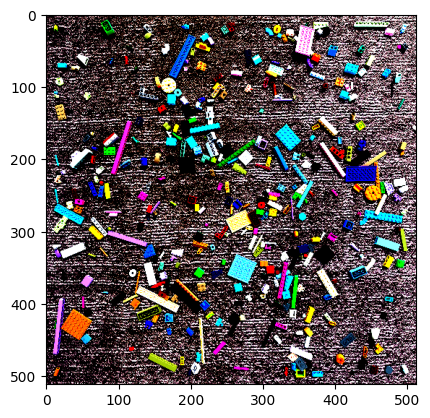

In [65]:
image, target = objdet_dataset[0]

plt.imshow(image.permute(1, 2, 0))
image.shape

In [66]:
for key, value in target.items():
    target[key] = target[key].to(device)
    print(target[key].type())

image.type()

torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.cuda.FloatTensor


'torch.FloatTensor'

In [67]:
effdet_model.eval()
with torch.inference_mode():
    predictions = pred_model(image.unsqueeze(dim=0).to(device))

predictions = predictions.squeeze()
predictions

tensor([[ -21.3435,  329.0963,   27.5040,  381.3369,    0.5346,   22.0000],
        [ -19.8982,  353.3470,   28.4464,  404.4343,    0.5345,   22.0000],
        [ -23.0875,  225.0323,   25.4967,  278.3102,    0.5345,   22.0000],
        ...,
        [ 199.8086, -152.5445,  379.7168,  208.4452,    0.5333,    9.0000],
        [  24.6961,  402.7282,   68.4058,  451.0696,    0.5333,   22.0000],
        [ 126.8105,  240.4730,  152.5827,  294.3159,    0.5333,   21.0000]],
       device='cuda:0')

In [68]:
pred_bboxes = predictions[:, :4]
pred_labels = predictions[:, -1]

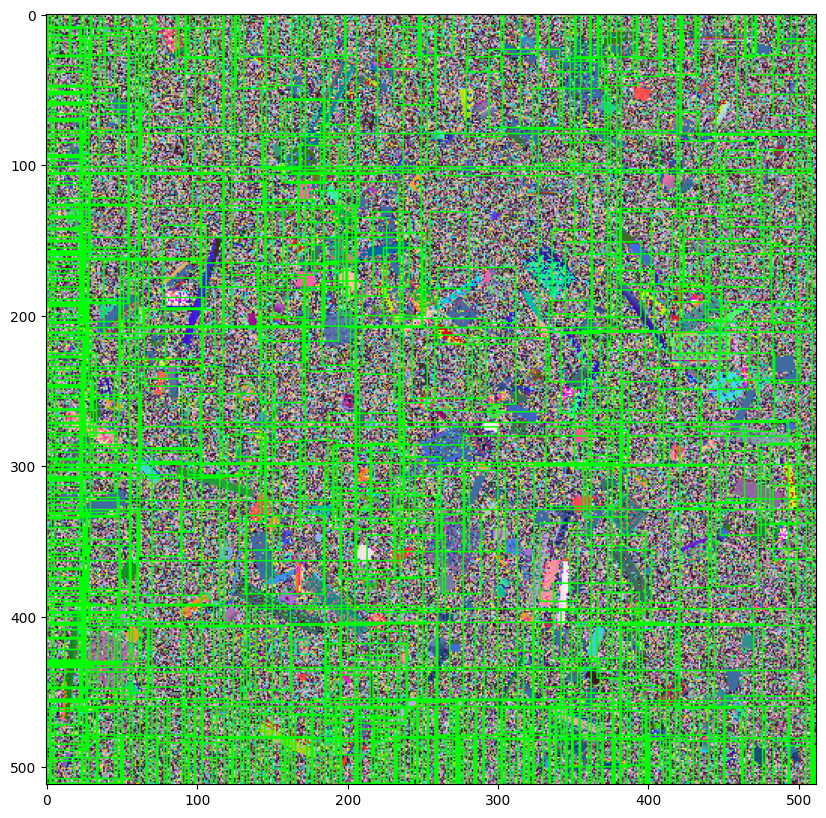

In [84]:
img_boxes = torchvision.utils.draw_bounding_boxes(image, pred_bboxes, colors=(0, 255, 0))

plt.figure(figsize = (10,10))
out = torchvision.utils.make_grid(img_boxes.unsqueeze(0).float(), normalize=True)

plt.imshow(out.numpy().transpose((1, 2, 0)))

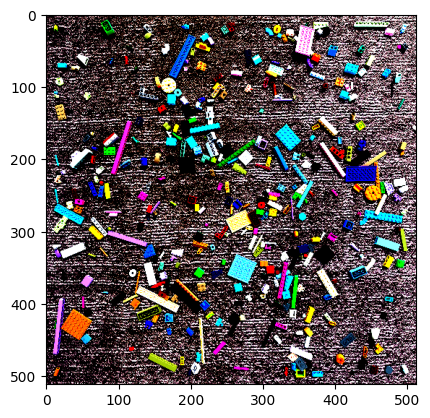

In [83]:
plt.imshow(image.permute(1, 2, 0))